# GeoPandas Weather Visualization
This notebook fetches weather data for Encina, Point Loma, and South Bay, visualizes it on a map of **San Diego County**, and includes interactive time sliders.

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import osmnx as ox
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=3, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


In [4]:
locations = {
    "Encina": (33.1387, -117.3258),
    "Point Loma": (32.6840, -117.2400),
    "South Bay": (32.5881, -117.0330)
}

gdf = gpd.GeoDataFrame(
    {"location": list(locations.keys())},
    geometry=gpd.points_from_xy([lon for _, lon in locations.values()],
                                [lat for lat, _ in locations.values()]),
    crs="EPSG:4326"
)
gdf

,location,geometry
0,Encina,POINT (-117.3258 33.1387)
1,Point Loma,POINT (-117.24 32.684)
2,South Bay,POINT (-117.033 32.5881)


In [5]:
def fetch_weather(lat, lon, start=None, end=None):
    if start is None:
        start = (datetime.utcnow() - timedelta(days=2)).strftime("%Y-%m-%d")
    if end is None:
        end = datetime.utcnow().strftime("%Y-%m-%d")

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m"],
        "start_date": start,
        "end_date": end,
        "timezone": "UTC"
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    time_start = hourly.Time()
    time_end = hourly.TimeEnd()
    interval = hourly.Interval()

    times = pd.date_range(
        start=pd.to_datetime(time_start, unit="s"),
        end=pd.to_datetime(time_end, unit="s"),
        freq=pd.Timedelta(seconds=interval),
        inclusive="left"
    )

    temp = hourly.Variables(0).ValuesAsNumpy()
    humidity = hourly.Variables(1).ValuesAsNumpy()
    wind = hourly.Variables(2).ValuesAsNumpy()

    min_len = min(len(times), len(temp), len(humidity), len(wind))
    return pd.DataFrame({
        "time": times[:min_len],
        "temperature": temp[:min_len],
        "humidity": humidity[:min_len],
        "wind_speed": wind[:min_len]
    })


In [6]:
weather_data = {}
for loc, (lat, lon) in locations.items():
    df = fetch_weather(lat, lon)
    df["location"] = loc
    weather_data[loc] = df

combined = pd.concat(weather_data.values(), ignore_index=True)
combined.head()

,time,temperature,humidity,wind_speed,location
0,2025-11-28 00:00:00,20.893000,46.0,4.104631,Encina
1,2025-11-28 01:00:00,17.942999,57.0,4.452954,Encina
2,2025-11-28 02:00:00,15.342999,75.0,0.360000,Encina
3,2025-11-28 03:00:00,14.592999,73.0,1.484318,Encina
4,2025-11-28 04:00:00,13.693000,72.0,3.319036,Encina


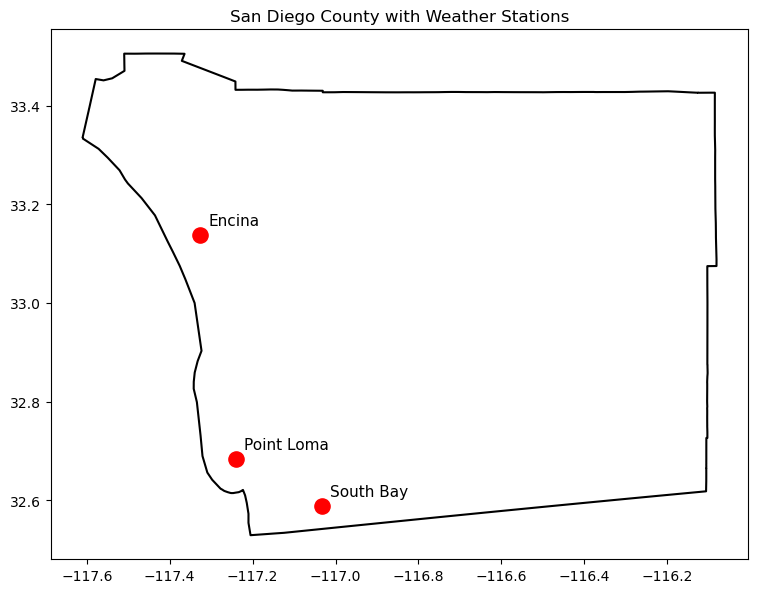

In [7]:
county = ox.geocode_to_gdf("San Diego County, California, USA").to_crs(4326)

fig, ax = plt.subplots(figsize=(9,9))
county.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)
gdf.plot(ax=ax, color="red", markersize=120)

for idx, row in gdf.iterrows():
    ax.text(row.geometry.x + 0.02, row.geometry.y + 0.02, row["location"], fontsize=11)

ax.set_title("San Diego County with Weather Stations")
plt.show()

In [8]:
combined['time'] = pd.to_datetime(combined['time'])
timestamps = sorted(combined['time'].unique())

def plot_spatial(timestamp, variable):
    snapshot = combined[combined['time'] == timestamp]
    spatial = gdf.merge(snapshot, on='location')

    fig, ax = plt.subplots(figsize=(9,9))
    county.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2)
    spatial.plot(column=variable, ax=ax, cmap='coolwarm', legend=True, markersize=200)

    for i, row in spatial.iterrows():
        ax.text(row.geometry.x+0.02, row.geometry.y+0.02, row["location"], fontsize=10)

    ax.set_title(f"{variable.title()} at {timestamp}")
    plt.show()

time_slider = widgets.SelectionSlider(options=timestamps, description="Time:")
var_dropdown = widgets.Dropdown(options=["temperature", "humidity", "wind_speed"], description="Variable:")

widgets.interact(plot_spatial, timestamp=time_slider, variable=var_dropdown)


interactive(children=(SelectionSlider(description='Time:', options=(Timestamp('2025-11-28 00:00:00'), Timestam…

<function __main__.plot_spatial(timestamp, variable)>